# Buffers or feedbacks?
Is it better to invest in institutions that establish feedbacks between human impacts and te state of the environment or reduce impacts to boost resiliance?

Buffers - p* / sigma rule roughgarden paper 

### Model
- Fish stock with convex dynamics + stochastic growth
- Bioeconomic equilibrium reached quickly by harvesters in the absence of regulations
- regulations set harvest limits
    - bioeconomic optimal harvest limit (no state uncertinaty)
    - optimal harvst limits with imperfect info about stock + imperfect implementation 
    - fixed harvest limits (with a buffer)
- objectives
    - Profit max
        - stock dependent costs 
        - risk aversion
    - conservaiton
        - Risk aversion


### Model 2
- comapre a buffer based policy to a simple uncerintay based policy in a non-stationary environment. 
- Structural uncertianty

### Analysis 
- solve for the optimal policy under a given set of objectives 
- compute the expected net present value for differnt inital stock sizes 
- value of perfect feedbacks is the differn between the optimal fixed and global optimum policy
- model with observaitonal errors illustrates a "realistic" intermediate
- How does the manamgent objective influence the value? does the value of the feedback flow from the harvest objective or the conservaiton objective?
- simpler models, how uch do more complex form of uncertianty boost the performance of feedback policies?

# Fixed harvest optimization

In [1]:
include("../src/MvGaussHermite.jl")
using Interpolations

In [74]:
mutable struct ValueFunction
    gridx
    gridV
    interpolation
end 

In [76]:
function (V::ValueFunction)(x)
    min_ = V.gridx[1]; max_ = V.gridx[end]
    min_itp = 1; max_itp = length(V.gridx)
    ind = (x - min_)/(max_-min_)
    ind = ind * (max_itp - min_itp) + min_itp 
    V.interpolation(ind)
end 

function ValueFunction(gridx,gridV)
    itp = interpolate(gridV, BSpline(Linear()))
    etpf = extrapolate(itp, Linear())    
    ValueFunction(gridx,gridV,etpf)
end 

function update_ValueFunction(V,gridV)
    itp = interpolate(gridV, BSpline(Linear()))
    etpf = extrapolate(itp, Linear())    
    V.gridV = gridV
    V.interpolation = etpf
end 

update_ValueFunction (generic function with 1 method)

In [21]:
Cov=zeros(1,1);Cov[1,1] = 0.05^2
quad = MvGaussHermite.init_mutable(30,[0.0],Cov)
nothing 

In [36]:
function dynamics(x,H,eps, Bmin, r, b, tau)
    
    B = exp(x)
    
    if B <= 0.025
        return 0.025,0.0
    end 
    
    if B < Bmin # if biomass is less than the minimum profitable biomass no harvest
        H = 0
    end
    
    if (B - H) < Bmin # if harvest stops when minimum profitable biomass is reached
        H = B - Bmin
    end 
    
    B = B-H
    B = r*B/(1+b*B)
    
    
    return log(B)+ eps - 0.5*tau^2, H
end 


function Bellman_eqn(x,pi,H,Bmin,r,b,tau,V,delta,quad)
    Hvals = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[2],quad.nodes)
    xt1 = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[1],quad.nodes)
    R = sum(broadcast(i -> pi(Hvals[i],exp(xt1[i])), 1:quad.m) .* quad.weights)
    EV = sum(V.(xt1) .* quad.weights)
    return R + delta*EV
end 


function Bellman!(V,pi,H,Bmin,r,b,tau,delta,quad)
    v_prime = broadcast(x -> Bellman_eqn(x,pi,H,Bmin,r,b,tau,V,delta,quad),V.gridx)
    return update_ValueFunction(V,v_prime)
end 


Bellman! (generic function with 1 method)

In [258]:
function performance(pi,H,Bmin,r,b,tau,delta)
    Bupper = 1.5*(r-1)/b
    Cov=zeros(1,1);Cov[1,1] = tau^2; quad = MvGaussHermite.init_mutable(m,[0.0],Cov)
    gridx = log(Bmin):0.1:log(Bupper); V = ValueFunction(gridx,zeros(length(gridx)))
    p = Plots.plot(exp.(V.gridx),V.gridV, label = "")
    for i in 1:100
        Bellman!(V,pi_,H,Bmin,r,b,tau,delta,quad)
    end
    return V, V(log(0.5*(r-1)/b))
end

performance (generic function with 1 method)

In [4]:
m = 30
H = 0.08
Bmin = 0.2
r = 1.8
b = 0.4
tau = sqrt(0.05)
delta = 0.95



pi_ (generic function with 1 method)

In [ ]:
Hvals = 0.1:0.025:0.3
tau = sqrt(0.01)
Vals = broadcast(H -> performance(pi,H,Bmin,r,b,sqrt(0.005),delta)[2], Hvals)
p1 = Plots.plot(Hvals,Vals,label = "tau = 0.025, delta = 0.95")
tau = sqrt(0.05)
Vals = broadcast(H -> performance(pi,H,Bmin,r,b,sqrt(0.05),delta)[2], Hvals)
Plots.plot!(p1,Hvals,Vals,label = "tau = 0.05, delta = 0.95")
tau = sqrt(0.01);delta = 0.99
Vals = broadcast(H -> performance(pi,H,Bmin,r,b,sqrt(0.005),delta)[2], Hvals)
Plots.plot!(p1,Hvals,Vals,label = "tau = 0.025, delta = 0.99", legend=:bottomleft)

## Fully optimal policy 

In [81]:
function dynamics(x,H,eps, Bmin, r, b, tau)
    
    B = exp(x)
    
    if B <= 0.026
        return log(0.025),0.0
    end 
    
    if (B - H) < 0.026 # if harvest stops when minimum profitable biomass is reached
        H = B - 0.026
    end 
    
    B = B-H
    B = r*B/(1+b*B)
    
    
    return log(B)+ eps - 0.5*tau^2, H
end 

dynamics (generic function with 1 method)

In [82]:
function EQ(x,pi,H,Bmin,r,b,tau,V,delta,quad)
    Hvals = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[2],quad.nodes)
    xt1 = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[1],quad.nodes)
    R = sum(broadcast(i -> pi(Hvals[i],exp(xt1[i])), 1:quad.m) .* quad.weights)
    EV = sum(V.(xt1) .* quad.weights)
    return R + delta*EV
end 


function EV(x,pi,Hvals,Bmin,r,b,tau,V,delta,quad)
    Qvals = broadcast(H -> EQ(x,pi,H,Bmin,r,b,tau,V,delta,quad), Hvals)
    return Qvals[argmax(Qvals)]
end 

function Bellman2!(V,pi,Hvals,Bmin,r,b,tau,delta,quad)
    v_prime = broadcast(x -> EV(x,pi,Hvals,Bmin,r,b,tau,V,delta,quad),V.gridx)
    return update_ValueFunction(V,v_prime)
end 

Bellman2! (generic function with 1 method)

In [83]:
function performance2(pi,H,Bmin,r,b,tau,delta)
    Bupper = 1.5*(r-1)/b
    Cov=zeros(1,1);Cov[1,1] = tau^2; quad = MvGaussHermite.init_mutable(m,[0.0],Cov)
    gridx = log(Bmin):0.1:log(Bupper); V = ValueFunction(gridx,zeros(length(gridx)))
    Hvals = 0.0:0.06:(Bupper/2)
    p = Plots.plot(exp.(V.gridx),V.gridV, label = "")
    for i in 1:100
        Bellman2!(V,pi_,Hvals,Bmin,r,b,tau,delta,quad)
    end
    return V, V(log(0.5*(r-1)/b))
end

performance2 (generic function with 1 method)

1
2
3


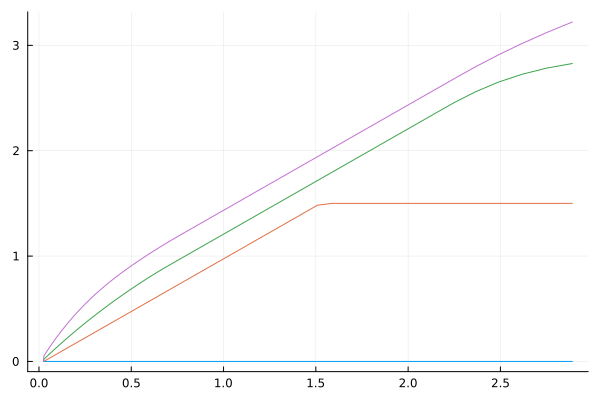

In [97]:
using Plots
m = 30
H = 0.08
Bmin = 0.2
r = 1.8
b = 0.4
tau = sqrt(0.05)
delta = 0.95

function pi_(H,B)
    return H
end


Bupper = 1.5*(r-1)/b
Cov=zeros(1,1);Cov[1,1] = tau^2; quad = MvGaussHermite.init_mutable(m,[0.0],Cov)
gridx = log(0.025):0.05:log(Bupper); V = ValueFunction(gridx,zeros(length(gridx)))
Hvals = 0.0:0.03:(Bupper/2)
p = Plots.plot(exp.(V.gridx),V.gridV, label = "")
for i in 1:3
    println(i)
    Bellman2!(V,pi_,Hvals,Bmin,r,b,tau,delta,quad)
    Plots.plot!(p,exp.(V.gridx),V.gridV, label = "")
end
p

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


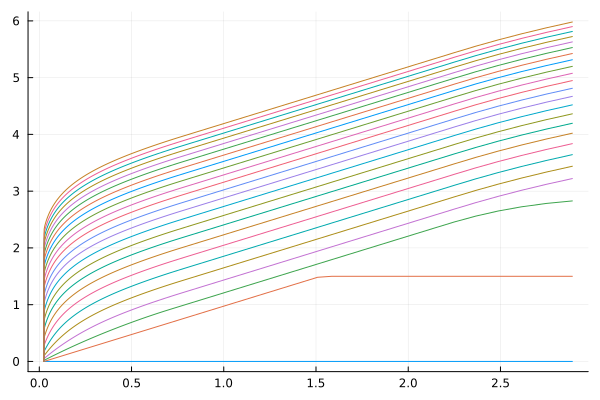

In [98]:
for i in 1:20
    println(i)
    Bellman2!(V,pi_,Hvals,Bmin,r,b,tau,delta,quad)
    Plots.plot!(p,exp.(V.gridx),V.gridV, label = "")
end
p

In [99]:
function policy(x,pi,Hvals,Bmin,r,b,tau,V,delta,quad)
    Qvals = broadcast(H -> EQ(x,pi,H,Bmin,r,b,tau,V,delta,quad), Hvals)
    return Hvals[argmax(Qvals)]
end 

policy (generic function with 1 method)

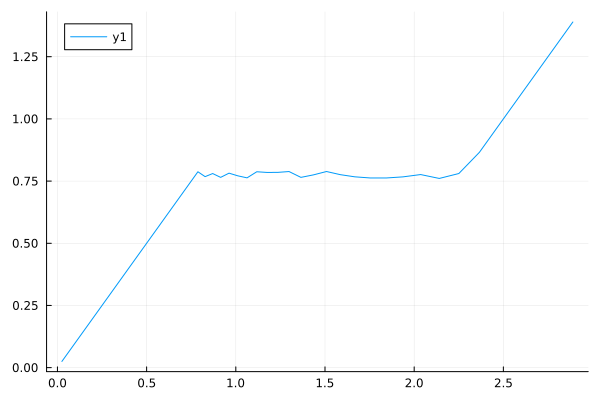

In [100]:
H = broadcast(x -> policy(x,pi_,Hvals,Bmin,r,b,tau,V,delta,quad), V.gridx)
Plots.plot(exp.(V.gridx),exp.(V.gridx) .- H)

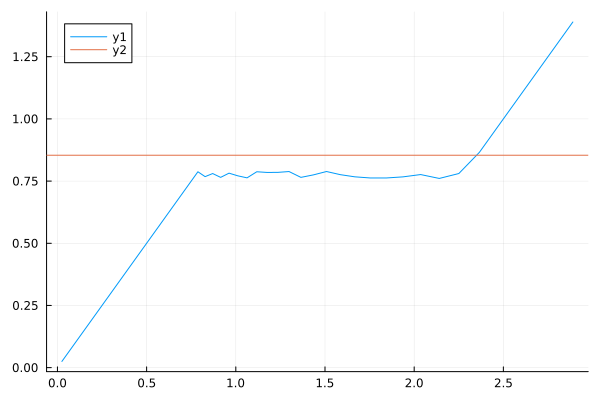

In [101]:
Plots.hline!([0.854])

In [80]:
function EQ(x,pi,H,Bmin,r,b,tau,V,delta,quad)
    Hvals = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[2],quad.nodes)
    xt1 = broadcast(eps -> dynamics(x,H,eps[1], Bmin, r, b, tau)[1],quad.nodes)
    
    R = sum(broadcast(i -> pi(Hvals[i],exp(xt1[i])), 1:quad.m) .* quad.weights)
    EV = sum(V.(xt1) .* quad.weights)
    
    return R, delta*EV
end 

EQ(log(0.025),pi_,10.0,Bmin,r,b,tau,V,delta,quad)

(0.0, 0.9365586747460383)

In [73]:
V(log(0.025)-10)

0.9365586747460383